In [2]:
cluster = 'a2744'
zclus = {'a2744' : 0.308,
         'm0416' : 0.396}
pgals = {'a2744' : [1.689791e-01, 1.965115e+00, 2.0],
        'm0416' : [3.737113e-01, 1.322081e+00, 2.0]}
nclus = {'a2744': "Abell 2744",
         'm0416' : "MACS 0416"}

import sys
utils = 'C:\\Users\\Jackson\\Jupyter projects\\Master\\Utility\\'
sys.path.insert(0, utils)

root = 'C:\\Users\\Jackson\\Jupyter projects\\'
sys.path.insert(0, root)
filebase = 'C:\\Users\\Jackson\\Jupyter projects\\Master\\' + nclus[cluster] + "\\Files\\"

import numpy as np
import numpy.ma as ma
from astropy.cosmology import FlatLambdaCDM
from os import listdir
from os.path import isfile, join
import MCUtil as MC
import DeltaSquared as DS
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statistics
import fitClusParallel as myfit

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
zlens = zclus[cluster]
imgdat = myfit.imgclass(root + "Files/" + cluster + '_images_0.5.dat',zlens,cosmo)

Read image data from file C:\Users\Jackson\Jupyter projects\Files/a2744_images_0.5.dat


In [3]:
scoreFile = np.load(filebase + "scores.npy", allow_pickle = True)
modelScores = scoreFile[()]
print(modelScores.keys())

dict_keys(['CM + sigmaDet', 'CM + sigmaProb', 'CM + prop', 'CM + box', 'CM + knn', 'CM + logistic', 'CM + svm', 'CM + gnb', 'CM + mnb', 'CM + cnb', 'CM + rf', 'CMP + knn', 'CMP + logistic', 'CMP + svm', 'CMP + gnb', 'CMP + mnb', 'CMP + cnb', 'CMP + rf', 'Coe + knn', 'Coe + logistic', 'Coe + svm', 'Coe + gnb', 'Coe + mnb', 'Coe + cnb', 'Coe + rf', 'CM + rnn', 'CMP + rnn', 'Coe + rnn'])


In [4]:
#Compare probabilities of models
probsBase = filebase + "Galaxy Probability Files\\"
models = list(modelScores.keys())
probabilities = []

for model in models:
    probs = np.loadtxt(probsBase + model)
    probabilities.append(probs[:,3])
    
probabilities = np.array(probabilities)

In [5]:
numModels = len(models)
dsMatrix = np.zeros((numModels, numModels))

for i in range(numModels):
    print(i)
    for j in range(numModels):
        dist1 = np.load(filebase + "\\MCMC\\"+ models[i] + "-main.npy")
        dist2 = np.load(filebase + "\\MCMC\\" + models[j] + "-main.npy")
        dscore = DS.TwoSampleTest(dist1, dist2)

        dsMatrix[i][j] = dscore

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [6]:
sample = np.loadtxt(probsBase + models[0])
maxmag = np.min(sample[:,2])
def mse(probs1, probs2):
    return np.sum((probs1 - probs2) * (probs1 - probs2))

def msExtra(probs1, probs2, mags):
    weighted = abs(probs1 - probs2) * (10 ** -(0.4*mags))
    return np.sum(weighted)

def msWithImg(posx, posy, probs1, probs2, mags):
    dist = 0
    ngal = len(posx)
    ni = imgdat.nimg
    for i in range(ngal):
        for j in range(ni):
            r = ((imgdat.xarr[j][0] - posx[i])**2 + (imgdat.xarr[j][1] - posy[i])**2)**0.5
            dist += abs(probs1[i] - probs2[i]) * (10 ** -(0.4*mags[i])) / r
    
    return dist

def msWithImg2(posx, posy, probs1, probs2, mags):
    dist = 0
    ngal = len(posx)
    ni = imgdat.nimg
    for i in range(ngal):
        for j in range(ni):
            r = ((imgdat.xarr[j][0] - posx[i])**2 + (imgdat.xarr[j][1] - posy[i])**2)
            dist += abs(probs1[i] - probs2[i]) * (10 ** -(0.4*mags[i])) / r
    
    return dist
    

numModels = len(models)

In [7]:
distMatrix = np.zeros((numModels, numModels))
for i in range(numModels):
    print(i)
    for j in range(numModels):
        probs1 = np.loadtxt(probsBase + models[i])
        probs2 = np.loadtxt(probsBase + models[j])
        
        distMatrix[i][j] = msWithImg(probs1[:,0], probs1[:,1], probs1[:,3], probs2[:,3], probs1[:,2])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [10]:
dsArr = []
distArr = []
for i in range(dsMatrix.shape[0]):
    for j in range(dsMatrix.shape[0]):
        if i != j:
            dsArr.append(dsMatrix[i, j])
            distArr.append(distMatrix[i, j])
            
dsArr = np.array(dsArr)
distArr = np.array(distArr)

[ 7.98555396e+13 -5.31365444e+06  9.20733842e-01]
R2 score: 0.7159242076684458


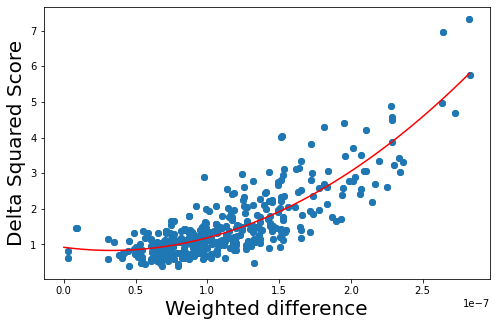

In [11]:
from sklearn.metrics import r2_score

fit = np.polyfit(distArr, dsArr, 2)
print(fit)

predict = np.poly1d(fit)
r2 = r2_score(dsArr, predict(distArr))

fig, ax = plt.subplots(figsize = (8, 5))

ax.set_ylabel("Delta Squared Score", size = 20)
ax.set_xlabel("Weighted difference", size = 20)

ax.scatter(distArr, dsArr)

xvals = np.linspace(0, np.max(distArr), 100)
ax.plot(xvals, predict(xvals), color = "red")
print("R2 score: {}".format(r2))